In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
from fastai.vision.all import *

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
data_path = Path('../input/digit-recognizer')
image_path = Path('../images')
image_path.mkdir(exist_ok=True)

In [4]:
df_train = pd.read_csv(data_path/'train.csv')
df_test = pd.read_csv(data_path/'test.csv')

In [5]:
df_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
for index, row in df_train.iterrows():
    label, digit = row[0], row[1:]
    file_path = image_path/"train"/str(label)
    file_path.mkdir(parents=True,exist_ok=True)
    file_name = f'{index}.jpg'
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(file_path/file_name)

/tmp/ipykernel_42/1647120212.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label, digit = row[0], row[1:]


In [60]:
for index, row in df_test.iterrows():
    digit = row
    file_path = image_path/"test"
    file_path.mkdir(parents=True,exist_ok=True)
    file_name = f'{index+1}.jpg'
    
    digit = digit.values
    digit = digit.reshape(28,28)
    digit = digit.astype(np.uint8)
    
    img = Image.fromarray(digit)
    img.save(file_path/file_name)

In [80]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=parent_label,
    batch_tfms=aug_transforms()
)

In [81]:
dls = dblock.dataloaders(
    image_path/'train',
    shuffle=True,
    device=torch.device('cuda')
)

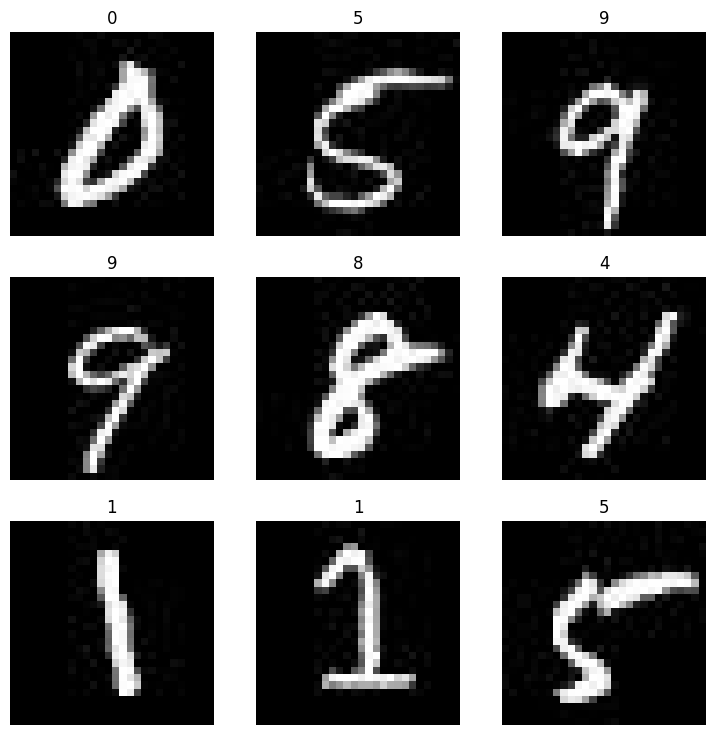

In [82]:
dls.valid.show_batch()

In [83]:
learn = vision_learner(dls, resnet50, metrics=error_rate)

In [77]:
learn.fine_tune(2)

epoch,train_loss,valid_loss,error_rate,time
0,1.700324,1.631599,0.478929,00:46


epoch,train_loss,valid_loss,error_rate,time
0,1.056591,0.982427,0.305833,00:55
1,0.827667,0.819390,0.258810,00:56


SuggestedLRs(valley=0.0014454397605732083)

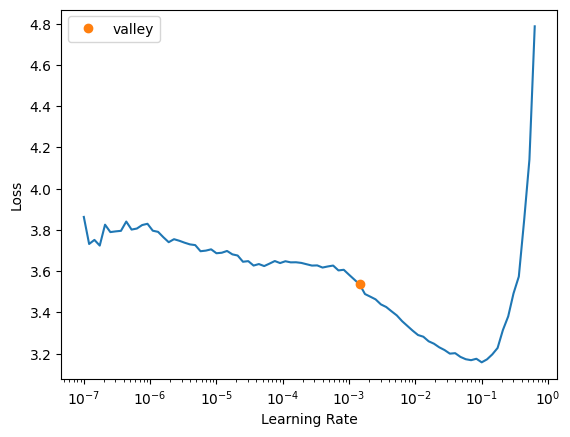

In [84]:
learn.lr_find()

In [ ]:
learn.fine_tune(15, base_lr=5e-3)

epoch,train_loss,valid_loss,error_rate,time


In [15]:
learn.export('digit_recog.pkl')

In [61]:
test_files = list((image_path / "test").glob("*.jpg"))

In [62]:
len(test_files)

28000

In [63]:
test_dl = learn.dls.test_dl(test_files)

In [70]:
predictions, _ = learn.tta(dl=test_dl)
predictions = np.argmax(predictions,axis=1)

In [71]:
predictions

tensor([7, 0, 7,  ..., 8, 7, 7])

In [72]:
image_ids = [int(path.stem) for path in test_files]

In [73]:
submission = pd.DataFrame({"ImageId": image_ids, "Label": predictions})
submission.head()

,ImageId,Label
0,21367,7
1,26150,0
2,21960,7
3,10435,9
4,6790,3


In [74]:
submission.to_csv('submission.csv',index=False)